# 🇵🇪 Tmin Perú — Zonal Stats + Visualizaciones + Políticas + Streamlit (v3 con descarga de datos)

**Integrantes:**

-Mack Valdivia

-Daniela Chumacero

**Resumen**
- Descarga automática de datos desde: `Mack-Valdivia/Tmin_Distritos_Peru/Datos` (GitHub).
- Estadísticas **zonal** de Tmin por **distrito** con ≥6 métricas (+ p5 personalizada).
- Visualizaciones: **histograma**, **boxplot**, **dispersión coloreada**, y **mapa** de todo el Perú.
- CSVs exportables, **conclusión** y **guía de políticas**.
- Celda que **genera un dashboard Streamlit** (`app/app.py`) con explicaciones y descargas.

In [ ]:
## Instal, en tu enviroment conda:
## pip install -r requirements.txt 

## (Opcional) Instalar dependencias si faltan
%pip install geopandas rasterio rasterstats rioxarray shapely pyproj matplotlib pandas numpy streamlit Unidecode requests

## 0) Descargar datos desde tu GitHub (se guardan en `./data/`)
Fuente: https://github.com/Mack-Valdivia/Tmin_Distritos_Peru/tree/main/Datos

In [4]:
from pathlib import Path
import requests

RAW_BASE = 'https://raw.githubusercontent.com/Mack-Valdivia/Tmin_Distritos_Peru/main/Datos/'
FILES = [
    'tmin_raster.tif',
    'DISTRITOS.shp', 'DISTRITOS.shx', 'DISTRITOS.dbf', 'DISTRITOS.prj', 'DISTRITOS.cpg'
]
DATA = Path('data'); DATA.mkdir(parents=True, exist_ok=True)

def fetch(url: str, out: Path):
    r = requests.get(url, timeout=120)
    r.raise_for_status()
    out.write_bytes(r.content)
    return out.name

downloaded = []
for fn in FILES:
    try:
        downloaded.append(fetch(RAW_BASE + fn, DATA / fn))
    except Exception as e:
        print(f'⚠️ No se pudo descargar {fn}: {e}')

print('Descargados:', downloaded)

Descargados: ['tmin_raster.tif', 'DISTRITOS.shp', 'DISTRITOS.shx', 'DISTRITOS.dbf', 'DISTRITOS.prj', 'DISTRITOS.cpg']


## 1) Preparación de entorno y rutas

In [5]:
import os, re
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

# Preferir Unidecode; si no está, usar unicodedata
try:
    from unidecode import unidecode as _unidecode
    def strip_accents_upper(s):
        return _unidecode(str(s)).upper() if s is not None else s
except Exception:
    import unicodedata
    def strip_accents_upper(s):
        if s is None: return s
        s = unicodedata.normalize('NFKD', str(s))
        s = ''.join(c for c in s if not unicodedata.combining(c))
        return s.upper()

DATA = Path('data'); DATA.mkdir(exist_ok=True, parents=True)
OUTPUTS = Path('outputs'); OUTPUTS.mkdir(exist_ok=True, parents=True)

PATH_RASTER = DATA / 'tmin_raster.tif'
PATH_SHAPE  = DATA / 'DISTRITOS.shp'

os.environ['SHAPE_RESTORE_SHX'] = 'YES'  # reconstruir .shx si falta


In [6]:
def normalize_keys_upper(gdf):
    return {c.upper().strip(): c for c in gdf.columns}

def build_or_find_ubigeo(gdf):
    cmap = normalize_keys_upper(gdf)
    for cu in ['UBIGEO','UBIGEO_DIST','UBIGEO_D','UBI_DIST','CODUBIGEO','COD_UBIGEO','ID_UBIGEO',
               'CODIGO_UBIGEO','UBIGEO6','UBIGEO_6','CODDIST','ID_DIST','COD_DIST','COD_DISTRITO']:
        if cu in cmap:
            col = cmap[cu]
            vals = pd.to_numeric(gdf[col], errors='coerce').fillna(-1).astype(int).astype(str)
            return vals.str.zfill(6)
    dd = next((cmap[x] for x in ['CCDD','CODDPTO','COD_DEPA','DEPARTAMENTO_ID','ID_DPTO','DPTO'] if x in cmap), None)
    pp = next((cmap[x] for x in ['CCPP','CODPROV','COD_PROV','PROVINCIA_ID','ID_PROV','PROV'] if x in cmap), None)
    di = next((cmap[x] for x in ['CCDI','CODDIST','COD_DIST','DISTRITO_ID','ID_DIST','DIST'] if x in cmap), None)
    if dd and pp and di:
        z = (gdf[dd].astype(str).str.extract(r'(\d+)', expand=False).fillna('').str.zfill(2) +
             gdf[pp].astype(str).str.extract(r'(\d+)', expand=False).fillna('').str.zfill(2) +
             gdf[di].astype(str).str.extract(r'(\d+)', expand=False).fillna('').str.zfill(2))
        if z.str.fullmatch(r'\d{6}').mean() > 0.8:
            return z
    for c in gdf.columns:
        s = gdf[c].astype(str).str.strip()
        if s.str.fullmatch(r'\d{6}').mean() > 0.8:
            return s
    raise ValueError('No se pudo detectar/crear UBIGEO de 6 dígitos. Revisa columnas del shapefile.')

def guess_scale_factor(sample_values):
    arr = np.asarray(sample_values)
    if arr.size == 0 or np.all(~np.isfinite(arr)):
        return 1.0
    vmax = np.nanmax(np.abs(arr))
    return 0.1 if 80 < vmax < 1000 else 1.0


## 2) Preparación de datos
1. Cargamos distritos y fijamos **EPSG:4326**.
2. Normalizamos **UBIGEO** y **nombres**.
3. Cargamos el **raster** y deducimos la escala (°C×10 → °C).

In [7]:
# 2.1 Distritos
gdf = gpd.read_file(PATH_SHAPE)
gdf = gdf.set_crs('EPSG:4326', allow_override=True) if gdf.crs is None else gdf.to_crs('EPSG:4326')
gdf['UBIGEO_OK'] = build_or_find_ubigeo(gdf)
cmap = normalize_keys_upper(gdf)
name_col = next((cmap[x] for x in ['NOMBDIST','NOMB_DIST','NOMBRE','DIST_NAME','DISTRITO','NOM_DIST','NAME'] if x in cmap), None)
gdf['NOMBRE_OK'] = (gdf[name_col] if name_col else gdf['UBIGEO_OK']).astype(str)
gdf['NOMBRE_OK'] = gdf['NOMBRE_OK'].astype(str).str.strip().apply(strip_accents_upper)
gdf['UBIGEO_OK'] = gdf['UBIGEO_OK'].astype(str).str.strip()
print('Distritos:', len(gdf))
gdf[['UBIGEO_OK','NOMBRE_OK']].head(3)

Distritos: 1873


,UBIGEO_OK,NOMBRE_OK
0,100902,CODO DEL POZUZO
1,100904,TOURNAVISTA
2,250305,ALEXANDER VON HUMBOLDT


In [8]:
# 2.2 Raster (multibanda)
src = rasterio.open(PATH_RASTER)
print('CRS raster:', src.crs, '| Bandas:', src.count, '| Dim:', src.height, 'x', src.width)
tags = src.tags() or {}
sf = None
for k in ['SCALE','scale_factor','Scale','SCALE_FACTOR']:
    if k in tags:
        try: sf = float(tags[k]); break
        except: pass
if sf is None:
    from rasterio.windows import Window
    w = Window(0,0, min(200, src.width), min(200, src.height))
    sample = src.read(1, window=w, masked=True)
    sf = guess_scale_factor(sample)
print('Factor de escala inferido:', sf)

CRS raster: EPSG:4326 | Bandas: 5 | Dim: 397 x 285
Factor de escala inferido: 1.0


## 3) Estadísticas zonales (distrito)
Métricas: `count, mean, min, max, std, percentile_10, percentile_90, percentile_5`.

In [9]:
def zonal_for_band(band_idx: int, year: int, scale: float=1.0, all_touched: bool=False):
    zs = zonal_stats(
        vectors=gdf,
        raster=str(PATH_RASTER),
        band=band_idx,
        stats=['count','mean','min','max','std','percentile_10','percentile_90','percentile_5'],
        all_touched=all_touched,
        nodata=None,
        geojson_out=False
    )
    df = pd.DataFrame(zs)
    if scale and scale != 1.0:
        for c in ['mean','min','max','std','percentile_10','percentile_90','percentile_5']:
            if c in df.columns: df[c] = df[c] * scale
    df['UBIGEO_OK'] = gdf['UBIGEO_OK'].values
    df['NOMBRE_OK'] = gdf['NOMBRE_OK'].values
    df['year'] = year
    return df

start_year = 2020
dfs = []
for b in range(1, src.count+1):
    dfs.append(zonal_for_band(b, year=start_year + (b-1), scale=sf))
df_zonal = pd.concat(dfs, ignore_index=True)
df_zonal.to_csv(Path('outputs') / 'zonal_tmin_por_distrito.csv', index=False)
df_zonal.head()

c:\Users\vmack\.conda\envs\yelp_scraper\lib\site-packages\rasterstats\io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


,min,max,mean,count,std,percentile_10,percentile_90,percentile_5,UBIGEO_OK,NOMBRE_OK,year
0,8.903979,22.604116,18.932154,107,3.430219,13.836891,22.358988,12.814143,100902,CODO DEL POZUZO,2020
1,19.775057,22.860834,22.290649,57,0.464426,21.992695,22.676195,21.528368,100904,TOURNAVISTA,2020
2,21.953405,22.141968,22.056366,6,0.076649,21.955791,22.137794,21.954597,250305,ALEXANDER VON HUMBOLDT,2020
3,21.661476,22.481043,22.263211,62,0.158932,22.042723,22.416752,21.969587,250302,IRAZOLA,2020
4,21.975763,22.385101,22.173068,22,0.118299,22.023388,22.361992,22.008291,250304,NESHUYA,2020


## 4) Visualizaciones estadísticas y mapa
Último año: **histograma**, **boxplot**, **dispersión** y **mapa** de todo el Perú.

In [10]:
latest = int(df_zonal['year'].max())
dly = df_zonal[df_zonal['year']==latest].copy()
print('Año visualizado:', latest, '| Distritos:', len(dly))

Año visualizado: 2024 | Distritos: 1873


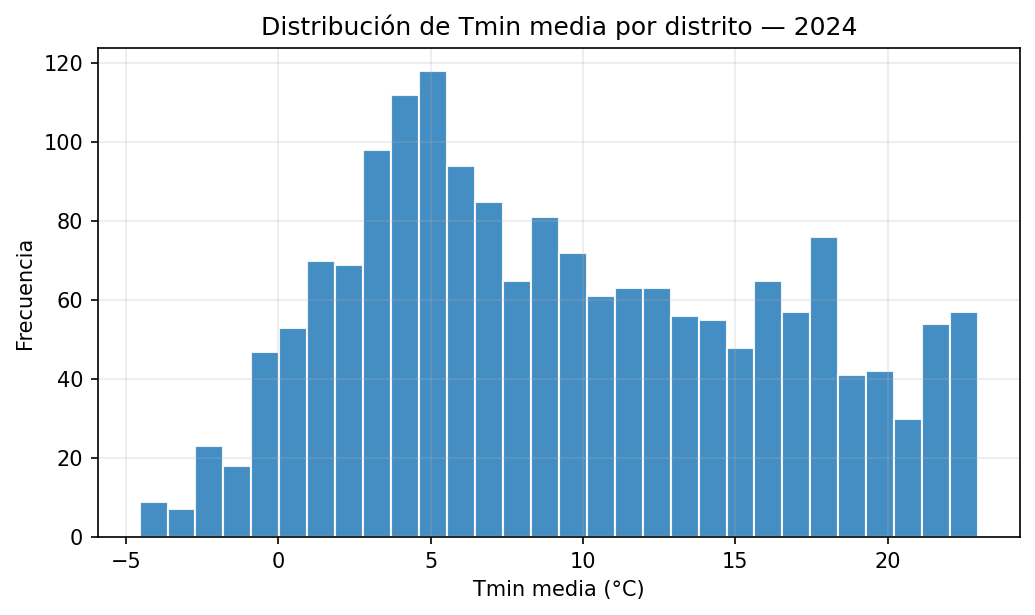

In [11]:
# 4.1 Histograma — Tmin media
fig, ax = plt.subplots(figsize=(7,4.2))
ax.hist(dly['mean'].dropna(), bins=30, color='#3182bd', edgecolor='white', alpha=0.9)
ax.set_title(f'Distribución de Tmin media por distrito — {latest}')
ax.set_xlabel('Tmin media (°C)'); ax.set_ylabel('Frecuencia'); ax.grid(alpha=0.25)
fig.tight_layout(); fig.savefig(Path('outputs') / f'hist_tmin_media_{latest}.png', dpi=220)
plt.show()

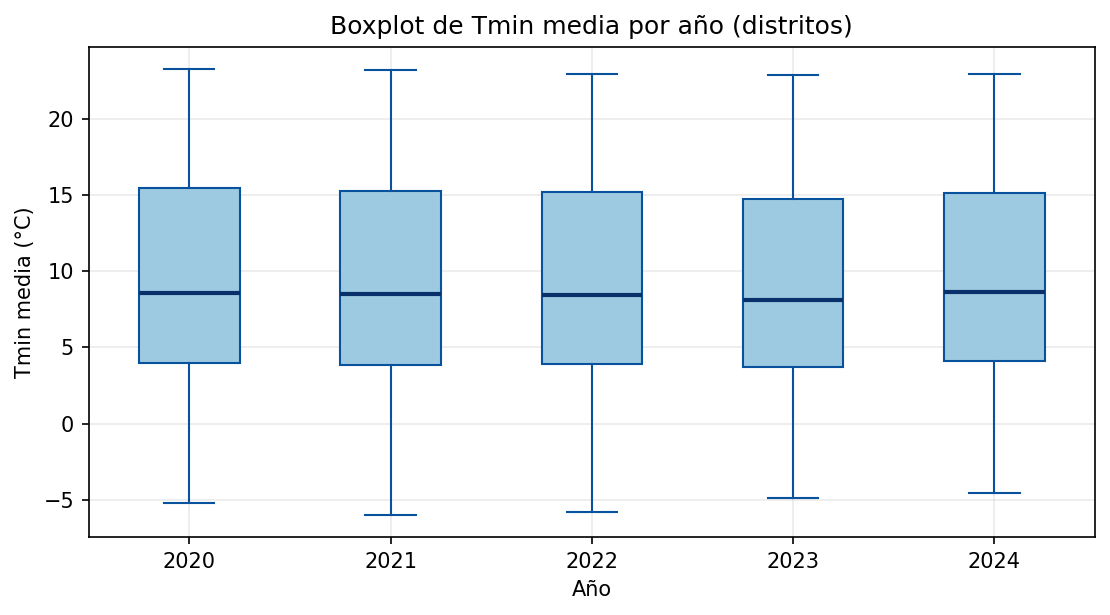

In [12]:
# 4.2 Boxplot — Tmin media por año (distritos)
fig, ax = plt.subplots(figsize=(7.5,4.2))
years = sorted(df_zonal['year'].unique())
data = [df_zonal[df_zonal['year']==y]['mean'].dropna().values for y in years]
ax.boxplot(data, patch_artist=True,
           boxprops=dict(facecolor='#9ecae1', color='#08519c'),
           medianprops=dict(color='#08306b', linewidth=2),
           whiskerprops=dict(color='#08519c'), capprops=dict(color='#08519c'))
ax.set_xticklabels(years)
ax.set_title('Boxplot de Tmin media por año (distritos)')
ax.set_xlabel('Año'); ax.set_ylabel('Tmin media (°C)'); ax.grid(alpha=0.25)
fig.tight_layout(); fig.savefig(Path('outputs') / 'boxplot_tmin_media_por_anio.png', dpi=220)
plt.show()

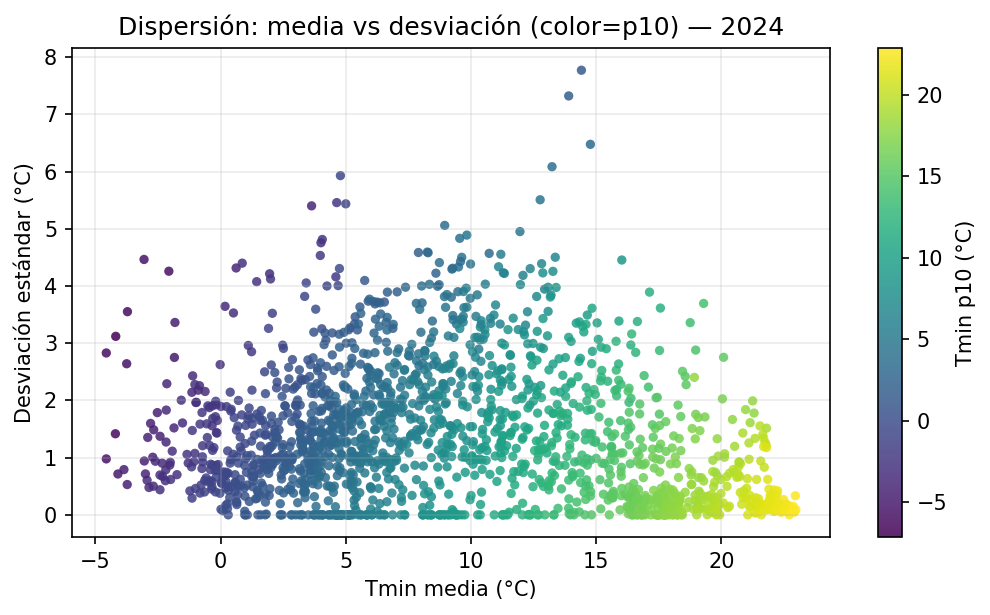

In [13]:
# 4.3 Dispersión coloreada — mean vs std (color = p10)
x = dly['mean'].values; y = dly['std'].values; c = dly['percentile_10'].values
fig, ax = plt.subplots(figsize=(7,4.2))
sc = ax.scatter(x, y, c=c, cmap='viridis', s=20, alpha=0.85, edgecolors='none')
cb = plt.colorbar(sc, ax=ax); cb.set_label('Tmin p10 (°C)')
ax.set_title(f'Dispersión: media vs desviación (color=p10) — {latest}')
ax.set_xlabel('Tmin media (°C)'); ax.set_ylabel('Desviación estándar (°C)'); ax.grid(alpha=0.25)
fig.tight_layout(); fig.savefig(Path('outputs') / f'scatter_mean_std_{latest}.png', dpi=220)
plt.show()

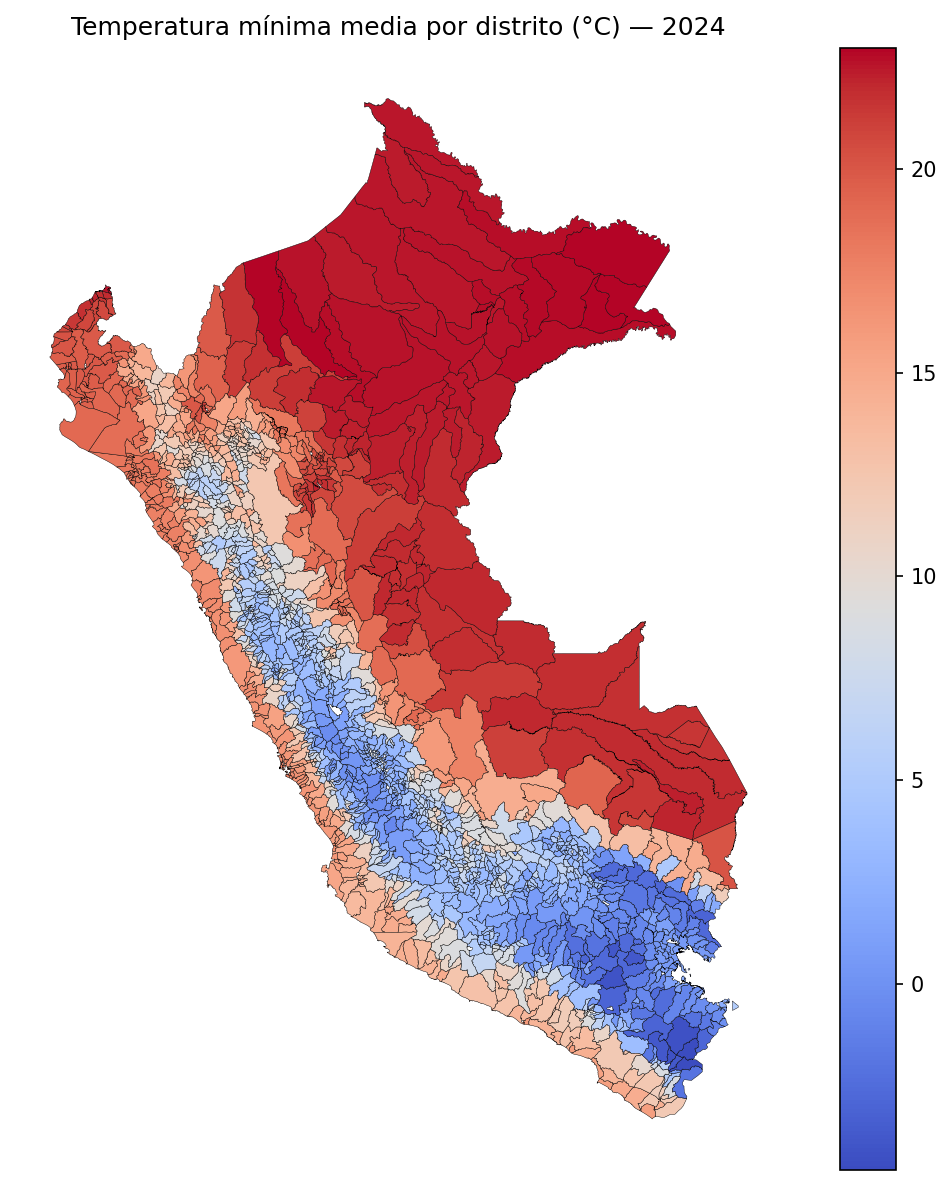

In [14]:
# 4.4 Mapa coroplético — Tmin media (Perú completo)
gplot = gdf[['UBIGEO_OK','NOMBRE_OK','geometry']].merge(dly[['UBIGEO_OK','mean']], on='UBIGEO_OK', how='left')
fig, ax = plt.subplots(figsize=(8,8))
gplot.plot(column='mean', cmap='coolwarm', legend=True, ax=ax, edgecolor='black', linewidth=0.2)
ax.set_axis_off(); ax.set_title(f'Temperatura mínima media por distrito (°C) — {latest}')
fig.tight_layout(); fig.savefig(Path('outputs') / f'mapa_tmin_media_{latest}.png', dpi=240)
plt.show()

In [15]:
# 4.5 Rankings Top/Bottom 15 + CSVs
cold15 = dly.nsmallest(15, 'mean')[['UBIGEO_OK','NOMBRE_OK','mean','percentile_10','percentile_90']]
hot15  = dly.nlargest(15, 'mean')[['UBIGEO_OK','NOMBRE_OK','mean','percentile_10','percentile_90']]
cold15.to_csv(Path('outputs') / f'top15_cold_{latest}.csv', index=False)
hot15.to_csv(Path('outputs') / f'top15_hot_{latest}.csv', index=False)
cold15.head(), hot15.head()

(     UBIGEO_OK             NOMBRE_OK      mean  percentile_10  percentile_90
 7541    230401                TARATA -4.561076      -6.175215      -3.388720
 7552    210502                CAPAZO -4.560061      -5.652370      -3.202446
 7571    210504            SANTA ROSA -4.197036      -6.378613      -2.484950
 7548    230406              SUSAPAYA -4.182688      -7.122831      -0.255336
 7655    040514  SAN ANTONIO DE CHUCA -4.096959      -5.024673      -3.261164,
      UBIGEO_OK       NOMBRE_OK       mean  percentile_10  percentile_90
 9327    160804          YAGUAS  22.973618      22.854120      23.103277
 9172    160704          MORONA  22.952683      22.668024      23.238251
 9168    160401  RAMON CASTILLA  22.926581      22.859756      22.986374
 9167    160404       SAN PABLO  22.887480      22.803846      22.963652
 9169    160705         PASTAZA  22.870794      22.721573      23.020863)

## 5) Conclusión y guía de políticas públicas
**Diagnóstico**: Distritos con **Tmin media** y **p10** más bajos concentran mayor riesgo sanitario (IRA/ARI), pérdidas agropecuarias y ausentismo escolar (altoandinos). En **Amazonía** hay **oleadas de frío** puntuales.

**Medidas priorizadas**
1. **Viviendas térmicas (ISUR)** — *Costo*: **S/ 2,500–6,000**/hogar; *KPI*: −X% IRA, −X% visitas por hipotermia.
2. **Kits antiheladas y protocolos escolares/sanitarios** — *Costo*: **S/ 150–400**/hogar/est.; *KPI*: +X% asistencia, −X días de interrupción.
3. **Calendarios agrícolas y refugios para ganado** — *Costo*: **S/ 80–200**/productor/año; **S/ 1,500–3,500**/cobertizo; *KPI*: −X% mortalidad y pérdidas.

**Implementación**: Priorización con mapas **Tmin (p10)** + vulnerabilidad (INEI/MIDIS); coordinación **SENAMHI, MINSA, MINEDU, MIDAGRI, VIVIENDA**; evaluación **antes-después** (p10 vs p50).

## 6) Generar app de Streamlit (dashboard con explicaciones)
Ejecuta esta celda y luego `streamlit run app/app.py`.

In [19]:
from pathlib import Path
app_dir = Path('app'); app_dir.mkdir(exist_ok=True, parents=True)
app_code = r'''import os
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import streamlit as st
from rasterstats import zonal_stats
from rasterio.windows import Window

st.set_page_config(page_title='Tmin Perú — Dashboard', layout='wide')
st.title('🇵🇪 Tmin Perú — Dashboard de Zonal Stats')
st.caption('App generada desde el notebook v4 (descarga datos + cache_resource)')

DATA = Path(__file__).resolve().parents[1] / 'data'
OUTPUTS = Path(__file__).resolve().parents[1] / 'outputs'
OUTPUTS.mkdir(exist_ok=True, parents=True)
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

def strip_accents_upper(s):
    try:
        from unidecode import unidecode
        return unidecode(str(s)).upper() if s is not None else s
    except Exception:
        import unicodedata
        if s is None: return s
        s = unicodedata.normalize('NFKD', str(s))
        s = ''.join(c for c in s if not unicodedata.combining(c))
        return s.upper()

def normalize_keys_upper(gdf):
    return {c.upper().strip(): c for c in gdf.columns}

def build_or_find_ubigeo(gdf):
    cmap = normalize_keys_upper(gdf)
    for cu in ['UBIGEO','UBIGEO_DIST','UBIGEO_D','UBI_DIST','CODUBIGEO','COD_UBIGEO','ID_UBIGEO','CODIGO_UBIGEO','UBIGEO6','UBIGEO_6','CODDIST','ID_DIST','COD_DIST','COD_DISTRITO']:
        if cu in cmap:
            col = cmap[cu]
            vals = pd.to_numeric(gdf[col], errors='coerce').fillna(-1).astype(int).astype(str)
            return vals.str.zfill(6)
    dd = next((cmap[x] for x in ['CCDD','CODDPTO','COD_DEPA','DEPARTAMENTO_ID','ID_DPTO','DPTO'] if x in cmap), None)
    pp = next((cmap[x] for x in ['CCPP','CODPROV','COD_PROV','PROVINCIA_ID','ID_PROV','PROV'] if x in cmap), None)
    di = next((cmap[x] for x in ['CCDI','CODDIST','COD_DIST','DISTRITO_ID','ID_DIST','DIST'] if x in cmap), None)
    if dd and pp and di:
        z = (gdf[dd].astype(str).str.extract(r'(\d+)', expand=False).fillna('').str.zfill(2) +
             gdf[pp].astype(str).str.extract(r'(\d+)', expand=False).fillna('').str.zfill(2) +
             gdf[di].astype(str).str.extract(r'(\d+)', expand=False).fillna('').str.zfill(2))
        return z
    for c in gdf.columns:
        s = gdf[c].astype(str).str.strip()
        if s.str.fullmatch(r'\d{6}').mean() > 0.8:
            return s
    raise ValueError('No se pudo detectar/crear UBIGEO de 6 dígitos.')

def guess_scale_factor(arr):
    if arr.size == 0 or np.all(~np.isfinite(arr)):
        return 1.0
    vmax = float(np.nanmax(np.abs(arr)))
    return 0.1 if 80 < vmax < 1000 else 1.0

@st.cache_resource(show_spinner=False)
def open_raster(path):
    src = rasterio.open(path)
    tags = src.tags() or {}
    sf = None
    for k in ['SCALE','scale_factor','Scale','SCALE_FACTOR']:
        if k in tags:
            try:
                sf = float(tags[k]); break
            except Exception:
                pass
    if sf is None:
        w = Window(0,0, min(200, src.width), min(200, src.height))
        sample = src.read(1, window=w, masked=True)
        sf = guess_scale_factor(np.asarray(sample))
    return src, sf

@st.cache_resource(show_spinner=False)
def load_vector(path):
    gdf = gpd.read_file(path)
    gdf = gdf.set_crs('EPSG:4326', allow_override=True) if gdf.crs is None else gdf.to_crs('EPSG:4326')
    gdf['UBIGEO_OK'] = build_or_find_ubigeo(gdf)
    cmap = normalize_keys_upper(gdf)
    name_col = next((cmap[x] for x in ['NOMBDIST','NOMB_DIST','NOMBRE','DIST_NAME','DISTRITO','NOM_DIST','NAME'] if x in cmap), None)
    gdf['NOMBRE_OK'] = (gdf[name_col] if name_col else gdf['UBIGEO_OK']).astype(str)
    gdf['NOMBRE_OK'] = gdf['NOMBRE_OK'].astype(str).str.strip().apply(strip_accents_upper)
    gdf['UBIGEO_OK'] = gdf['UBIGEO_OK'].astype(str).str.strip()
    return gdf

# Sidebar — inputs
st.sidebar.header('Datos')
vector_name = st.sidebar.text_input('Shapefile (.shp)', 'DISTRITOS.shp')
raster_name = st.sidebar.text_input('Raster GeoTIFF', 'tmin_raster.tif')
start_year = st.sidebar.number_input('Año Banda 1', 1900, 2100, 2020)

vector_path = DATA / vector_name
raster_path = DATA / raster_name

if not vector_path.exists() or not raster_path.exists():
    st.error('No encuentro datos en ./data. Ejecuta la celda 0 del notebook para descargarlos.'); st.stop()

gdf = load_vector(vector_path)
src, sf = open_raster(raster_path)
st.sidebar.success(f'Vector OK ({len(gdf)}) · Raster OK ({src.count} banda/s) · scale={sf}')

band = st.sidebar.slider('Banda', 1, src.count, 1)
year = int(start_year + (band-1))

@st.cache_data(show_spinner=True)
def compute_zonal(band, year):
    zs = zonal_stats(
        vectors=gdf, raster=str(raster_path), band=band,
        stats=['count','mean','min','max','std','percentile_10','percentile_90','percentile_5'],
        all_touched=False, nodata=None, geojson_out=False
    )
    df = pd.DataFrame(zs)
    if sf and sf != 1.0:
        for c in ['mean','min','max','std','percentile_10','percentile_90','percentile_5']:
            if c in df.columns: df[c] = df[c]*sf
    df['UBIGEO_OK'] = gdf['UBIGEO_OK'].values
    df['NOMBRE_OK'] = gdf['NOMBRE_OK'].values
    df['year'] = year
    return df

df = compute_zonal(band, year)
st.subheader(f'Resultados — Año {year} (Banda {band})')

# KPIs
c1,c2,c3,c4 = st.columns(4)
c1.metric('Distritos', f'{df.shape[0]:,}')
c2.metric('Tmin media (°C)', f"{df['mean'].mean():.2f}")
c3.metric('Tmin p10 (°C)', f"{df['percentile_10'].mean():.2f}")
c4.metric('Tmin p90 (°C)', f"{df['percentile_90'].mean():.2f}")

st.info('Las estadísticas zonales promedian los valores del ráster dentro de cada polígono (distrito). Métricas p10/p90 describen caudas frías/cálidas.')

# Gráficos
st.markdown('### Distribución (Histograma)')
fig, ax = plt.subplots(figsize=(6.3,3.6))
ax.hist(df['mean'].dropna(), bins=30, color='#3182bd', edgecolor='white', alpha=0.9)
ax.set_xlabel('Tmin media (°C)'); ax.set_ylabel('Frecuencia'); ax.grid(alpha=0.25)
st.pyplot(fig, clear_figure=True)

st.markdown('### Caja y bigotes (Boxplot ≈ año/banda seleccionada)')
fig2, ax2 = plt.subplots(figsize=(6.3,3.6))
ax2.boxplot([df['mean'].dropna().values], patch_artist=True,
            boxprops=dict(facecolor='#9ecae1', color='#08519c'),
            medianprops=dict(color='#08306b', linewidth=2),
            whiskerprops=dict(color='#08519c'), capprops=dict(color='#08519c'))
ax2.set_xticklabels([str(year)])
ax2.set_ylabel('Tmin media (°C)'); ax2.grid(alpha=0.25)
st.pyplot(fig2, clear_figure=True)

st.markdown('### Dispersión coloreada (media vs std; color = p10)')
fig3, ax3 = plt.subplots(figsize=(6.3,3.6))
sc = ax3.scatter(df['mean'], df['std'], c=df['percentile_10'], cmap='viridis', s=20, alpha=0.85, edgecolors='none')
cb = plt.colorbar(sc, ax=ax3); cb.set_label('Tmin p10 (°C)')
ax3.set_xlabel('Tmin media (°C)'); ax3.set_ylabel('Desv. estándar (°C)'); ax3.grid(alpha=0.25)
st.pyplot(fig3, clear_figure=True)

st.markdown('### Mapa coroplético — Tmin media (°C)')
gplot = gdf[['UBIGEO_OK','NOMBRE_OK','geometry']].merge(df[['UBIGEO_OK','mean']], on='UBIGEO_OK', how='left')
fig4, ax4 = plt.subplots(figsize=(7.5,7.5))
gplot.plot(column='mean', cmap='coolwarm', legend=True, ax=ax4, edgecolor='black', linewidth=0.2)
ax4.set_axis_off(); ax4.set_title(f'Tmin media por distrito — {year}')
st.pyplot(fig4, clear_figure=True)

# Tablas con explicación
st.markdown('### Tablas y descarga')
st.caption('Top-15 más fríos / más cálidos para priorización territorial')
cold15 = df.nsmallest(15, 'mean')[['UBIGEO_OK','NOMBRE_OK','mean','percentile_10','percentile_90']]
hot15  = df.nlargest(15, 'mean')[['UBIGEO_OK','NOMBRE_OK','mean','percentile_10','percentile_90']]
colA, colB = st.columns(2)
with colA:
    st.dataframe(cold15.style.format({'mean':'{:.2f}','percentile_10':'{:.2f}','percentile_90':'{:.2f}'}), use_container_width=True)
    st.download_button('Descargar CSV (Fríos)', cold15.to_csv(index=False), file_name=f'top15_cold_{year}.csv', mime='text/csv')
with colB:
    st.dataframe(hot15.style.format({'mean':'{:.2f}','percentile_10':'{:.2f}','percentile_90':'{:.2f}'}), use_container_width=True)
    st.download_button('Descargar CSV (Cálidos)', hot15.to_csv(index=False), file_name=f'top15_hot_{year}.csv', mime='text/csv')

master = gplot.drop(columns='geometry').rename(columns={'mean':'tmin_mean_c'})
st.download_button('Descargar tabla completa (CSV)', master.to_csv(index=False), file_name=f'tmin_distritos_{year}.csv', mime='text/csv')

st.markdown('---')
st.subheader('Conclusión y guía de políticas públicas')
st.markdown("""Distritos con **Tmin media** y **p10** más bajos concentran mayor riesgo sanitario (IRA/ARI),
pérdidas agropecuarias y ausentismo escolar, sobre todo en zonas altoandinas. En Amazonía aparecen
**oleadas de frío** puntuales.""")
st.markdown('**Medidas**: viviendas térmicas (ISUR), kits antiheladas, calendarios agrícolas y refugios para ganado; protocolos MINSA/MINEDU ante alertas.')
st.caption('KPIs: −X% IRA; −X% mortalidad de alpacas/ovinos; +X% asistencia escolar; −X días de interrupción.')
'''
(app_dir / 'app.py').write_text(app_code, encoding='utf-8')
print('✓ app/app.py generado (con cache_resource y cadenas correctas)')

✓ app/app.py generado (con cache_resource y cadenas correctas)
